In [67]:
import numpy as np
import pandas as pd
# import torch
# import scipy
import matplotlib.pyplot as plt
import seaborn

import plotly.graph_objects as go
import plotly.express as px

from tqdm import tqdm

import torch.nn.functional as F
import torch

%load_ext autoreload
%autoreload 2
from help_functions.make_html_visual import make_html_visual
from help_functions.make_conv_2d import make_conv_2d
from help_functions.make_conv_2d_torch import make_conv_2d_torch
from help_functions.make_conv_3d_torch import make_conv_3d_torch


from help_functions.make_scatter_visual import make_scatter_visual

# from make_scatter_visual import make_scatter_visual
# from make_conv_2d import make_conv_2d

from IPython.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
raw_data = np.loadtxt('./models/BuddaAll.txt').reshape(-1)
int_cast_data = np.trunc(raw_data*np.power(10,3)).astype(int).reshape(-1, 3)

In [20]:
int_cast_data.min(axis=0)

array([-46,  49, -47])

In [41]:
shifted = (int_cast_data - int_cast_data.min(axis=0) + np.array([10,10,10]))

sizes = (int_cast_data.max(axis=0) - int_cast_data.min(axis=0) + np.array([20,20, 20])).astype(int)
tensor_3d = torch.zeros(tuple(sizes), dtype=int)

tensor_3d[shifted[:, 0], shifted[:, 1], shifted[:, 2]] = 1

# tensor_rotated_90 = np.rot90(tensor_3d, k=1, axes=(0, 1))

# Для поворота на 180 градусов:
tensor_rotated_90 = torch.rot90(input = tensor_3d, k=1, dims=(1, 2))

# Для поворота на 270 градусов:
# tensor_rotated_270 = np.rot90(tensor_3d, k=3, axes=(0, 1))

In [30]:
make_scatter_visual(tensor_rotated_90, 'budda_input_data')

Всего точек: 64312
Размер тензора: torch.Size([101, 101, 218])
Плотность: 0.028920


In [39]:
make_html_visual(tensor_3d=tensor_3d, name='budda-raw', colorscale='Jet')
# HTML(filename='./htmls/budda-raw.html')


Файл сохранен в ./htmls/budda-raw.html


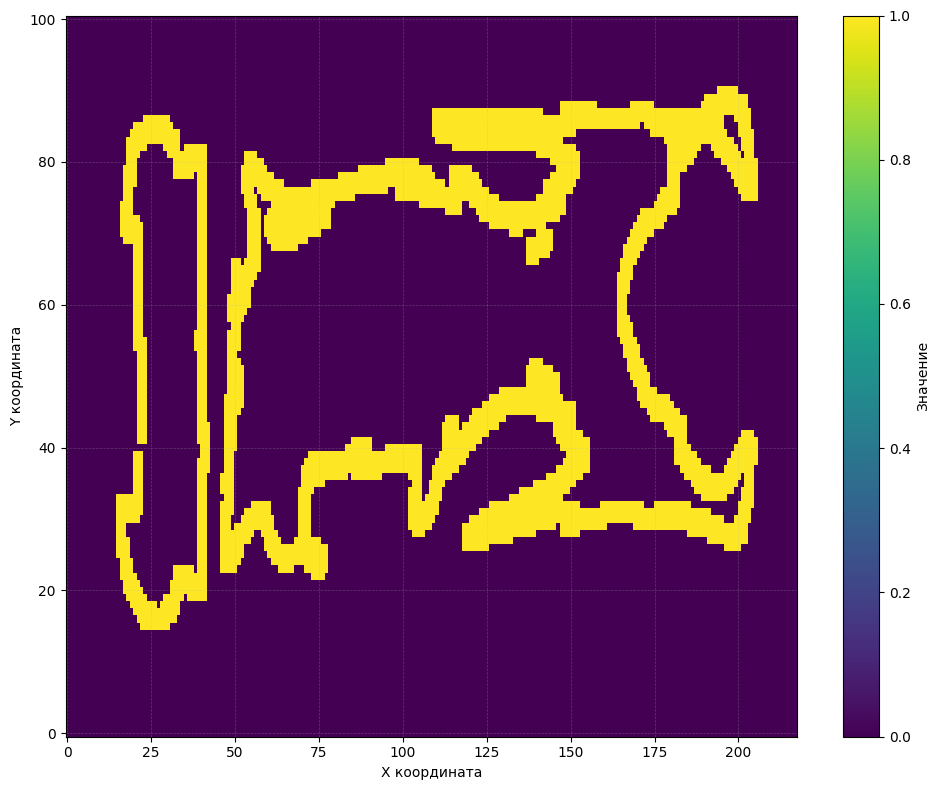

In [66]:
tensor_slice = tensor_3d[:,:, 30]
kernel = torch.ones(size=(3,3))

conv_result = make_conv_2d_torch(source=tensor_slice, kernel=kernel)


plt.figure(figsize=(10, 8))
    
plt.imshow(conv_result, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/budda-2d-slice-after-conv.png')
plt.show()



In [15]:
def make_conv_3d(source, kernel):

    result = np.zeros(shape = source.shape)

    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    pad_length = kernel.shape[2] // 2
    
    source_pad = np.pad(source, 
                        pad_width=((pad_height, pad_height), (pad_width, pad_width), (pad_length, pad_length)), 
                        mode='constant', 
                        constant_values=0)
                        

    source_pad_height, source_pad_widht, source_pad_length = source_pad.shape

    kernel_height, kernel_widht, kernel_length = kernel.shape

    for i in tqdm(range(source_pad_height - 2*pad_height)):
        for j in (range(source_pad_widht - 2*pad_width)):
            for k in (range(source_pad_length - 2*pad_length)):

                value = min(
                            np.sum(source_pad[i:i + kernel_height, j: j + kernel_widht, k: k + kernel_length]*kernel),
                            1
                            )
                # print(i,j, k, value)
                result[i][j][k] = value


    return result

In [70]:
kernel = torch.ones(size=(9,9,9))

voxel_model = make_conv_3d_torch(tensor_3d, kernel=kernel)

In [71]:
make_html_visual(voxel_model[::2,::2,::2], 'voxel_model_budda_9_rare')
# HTML(filename='./htmls/voxel_model_budda_5_rare.html')

Файл сохранен в ./htmls/voxel_model_budda_9_rare.html


In [28]:
!pwd

/home/alexander/DIPLOM


In [29]:
HTML(filename="/home/alexander/DIPLOM/htmls/voxel_model_budda_7")

FileNotFoundError: [Errno 2] No such file or directory: '/home/alexander/DIPLOM/htmls/voxel_model_budda_7'

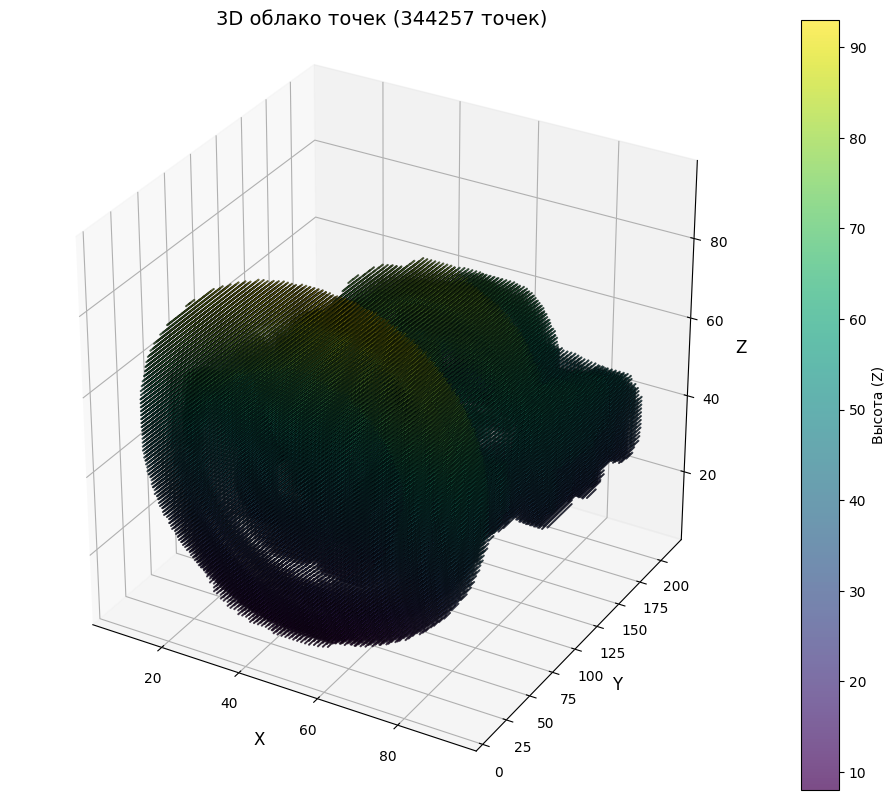

Всего точек: 344257
Размер тензора: (101, 218, 101)
Плотность: 0.154804


In [23]:
make_scatter_visual(voxel_model)

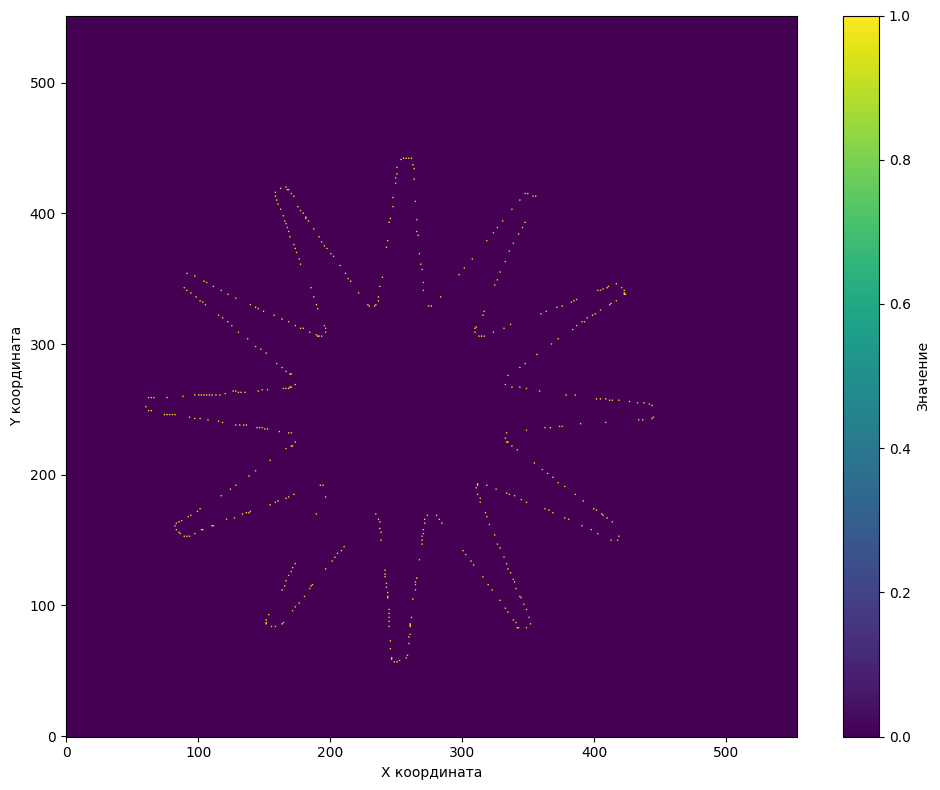

In [68]:
tensor_slice = tensor_3d[:,:, 150]

plt.figure(figsize=(10, 8))
    
plt.imshow(tensor_slice, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

# plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [7]:
5%5

0